## Introduction to GANs

GANs are a type of deep learning model used for generating new data samples that resembles given dataset.
<br>
<br>
In GANs, we have two type of neural network -
1. Generator
2. Discriminator

**Generator** - It takes random noise as input and generates data similar to real datset. Its goal is to create samples that are indistinguishable from real data, effectively fooling the Discriminator.

**Discriminator** - It takes real or generated data as input and classifies them as real(from dataset) or fake(from generator). Its goal is to distinguish between real and generated data as accurately as possible.

### How GANs Work
The generator and discriminator are trained simultaneously in a min-max game.
<br>
- The Generator tries to minimize the Discriminator's ability to classify generated data as fake.
<br>
- The Discriminator tries to maximize its ability to correctly predict the generated data as real or fake.

This is modeled mathematically as:

```math
\min_G \max_D V(G, D) = \mathbb{E}_{x \sim p_{\text{data}}}[\log D(x)] + \mathbb{E}_{z \sim p_z}[\log(1 - D(G(z)))]
```

where,
- x : real data sample.
- z : random noise input to the Generator.
- G(z) : generated data sample.
- D(x) : Discriminator's probability that x is real.



## Dataset description and preprocessing steps.

We are using MNIST dataset which contains 70,000 greyscale images of handwritten digits from 0 to 9. So discriminator have ten classes to predict from.
Each image is 28*28 pixels and have corresponding digit labels (0-9).
<br>
<br>
**Dataset split:**
- Training set : 60,000 images
- Test set : 10,000 images

**Preprocessing Steps:**

1. **Loading the dataset :**  It is done using load_data() function from keras.datasets.mnist
   ```python
   (train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
   ```

2. **Reshaping the Images :**
   ```python
   train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
   ```
   - Each image is reshaped from (28, 28) to (28, 28, 1) to explicitly include the channel dimension (grayscale has one channel).
   - This ensures compatibility with the generator and discriminator models, which are designed to work with 4D tensors: (batch_size, height, width, channels).

3. **Normalizing the pixel values :**
   ```python
   train_images = (train_images - 127.5) / 127.5
   ```
   - MNIST pixel values range from 0 to 255. They are normalized to [-1, 1]
   - The generator uses a tanh activation function, which outputs values in the range of [-1, 1]
   - Normalizing inputs to the same range improves model stability and convergence during training.

4. **Shuffling and Batching :**
   ```python
   BUFFER_SIZE = 60000
   BATCH_SIZE = 256

   train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
   ```
   - The dataset is shuffled with a buffer size of 60,000 (the total number of MNIST training images).
   - The dataset is divided into batches of size 256 and each batch has a shape [256, 28, 28, 1]. Batching improves training efficiency and leverages parallel computation.
   

In [21]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras import layers
import time

In [22]:
# Load the dataset
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [23]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32') # Reshape the images from (28, 28) to (28, 28, 1) as needed by CNNs
train_images = (train_images - 127.5) / 127.5  # Normalize to [-1, 1]

In [24]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [25]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Model Architecture

## Generator

**Dense Layer:**
- The first dense layer maps the input noise into a vector of size 7×7×256, effectively shaping the foundation for the subsequent layers.
- Batch Normalization normalizes the activations to stabilize and accelerate training.
- A LeakyReLU activation function introduces non-linearity and mitigates the vanishing gradient problem.
  
**Reshape Layer:**
- Reshapes the 1D output of the dense layer into a 3D feature map of shape 7×7×256, preparing it for the transposed convolutional layers.
  

**First Transposed Convolutional Layer:**

- Output Shape: (None,7,7,128)
- Applies a 3×3 kernel with a stride of 1×1 and 'same' padding to refine the initial feature maps.
- Batch Normalization and LeakyReLU are applied for stability and activation.

**Second Transposed Convolutional Layer:**

- Output Shape: (None,14,14,64)
- Upsamples the feature maps by doubling their spatial dimensions using a stride of 2×2.
- Again, Batch Normalization and LeakyReLU ensure the generator learns efficiently.

**Final Transposed Convolutional Layer:**

- Output Shape: (None,28,28,1)
- Produces the final grayscale image using a 2×2.
- Uses the tanh activation function to scale pixel values to the range [−1,1], matching the normalized input range of the discriminator.

In [26]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # None is the batch size

    model.add(layers.Conv2DTranspose(128, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (3, 3), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

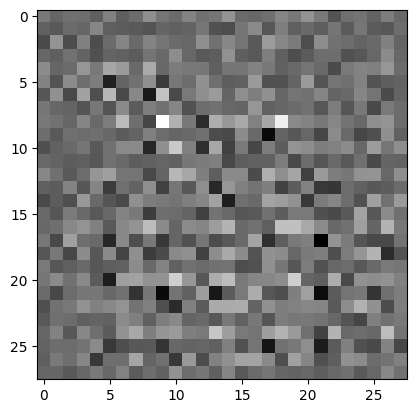

In [27]:
# Use the (as yet untrained) generator to create an image.
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

## Discriminator

**Convolutional Layers:**
- Two convolutional layers are used, each with a kernel size of 3×3, stride of 2×2, and 'same' padding to maintain spatial integrity during feature extraction.
- A LeakyReLU activation function (α=0.2) ensures better gradient flow for negative activations, addressing the "dying ReLU" problem.
- Batch Normalization is applied after each convolution to stabilize and accelerate training by normalizing feature maps.
  
**Dropout:**
- A dropout rate of 0.4 is applied after each convolutional layer.
- This reduces the risk of overfitting and ensures the model generalizes well to unseen data.

**Flatten Layer:**
- Converts the 2D feature maps into a 1D vector, preparing the data for the dense layer.
  
**Output Layer:**
- A single unit with a sigmoid activation function outputs a scalar value.
- This scalar represents the probability that the input image is "real" (close to 1) or "fake" (close to 0).

In [28]:
def make_discriminator_model():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same',
                      kernel_regularizer=tf.keras.regularizers.l2(0.001),
                      input_shape=[28, 28, 1]),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.4),

        layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same',
                      kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.4),

        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

## Loss Functions

We use BinaryCrossentropy loss here because the model will predict only two values i.e real or fake

In [29]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator Loss
- The discriminator’s loss measures its ability to classify real images as "real" and generated images as "fake."
- The discriminator tries to output 1 for real images.
- The discriminator tries to output 0 for fake images.

In [41]:
# Discriminator loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

### Generator Loss

- The generator’s loss measures its ability to fool the discriminator into classifying generated images as "real."
- The generator aims for the discriminator to output 1 for its images.

In [42]:
# Generator loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### Optimizers

- Adam optimizer is used in both descriminator and generator
- Learning rate is $1 * 10^-4$
- Low learning rate ensures stable training
- beta helps us smooth out oscillations during training

In [43]:
# Set up the optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

In [44]:
generator = make_generator_model()
discriminator = make_discriminator_model()

In [45]:
# Save checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [46]:
# Creates a fixed noise vector to generate images for consistent evaluation during training.
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16 # for a 4x4 grid

seed = tf.random.normal([num_examples_to_generate, noise_dim])

## Training Strategy
- Firstly, noise vector of shape [BATCH_SIZE, noise_dim] is created.
- gen_tape and disc_tape tracks operations for generator and discriminator simultaneously so there gradient can be calculated.
- Then, discriminator is evaluated on real images from the dataset with Gaussian noise of mean = 0 and standard deviation = 0.05, to prevent overfitting and make the discriminator robust
- Similarly, discriminator is also evaluated on fake images produced by generator.
- The generator loss encourages the generator to produce images that the discriminator classifies as real.
- The discriminator loss measures how well the discriminator can distinguish real images from fake ones.
- Computes the gradients of the generator's loss and discriminator's loss with respect to its trainable variables.
- Updates the generator's weights and discriminator's weights using its gradients.
- Return the generator and discriminator loss for monitoring.

In [47]:
gen_losses = []
disc_losses = []

In [48]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
 
# forward pass
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

# backward pass
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [49]:
# Generate and save a grid of images to monitor the progress of the generator during training
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    os.makedirs('generated_images', exist_ok=True)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig(f'generated_images/image_at_epoch_{epoch:04d}.png')
    plt.show()

### Training and vizualization

- Outer loop iterates for 100 epochs and start records the start time of each epoch
- For each image_batch g_loss and d_loss is calculated and appened to the respective lists
- We call the generate_and_save_images function to produce and save images from the generator
- The model is saved after every 15 epochs
- Display the time taken for each epoch
- Save the model after all the epochs are completed
- Plot the generator and discriminator loss

In [50]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        epoch_gen_loss = []
        epoch_disc_loss = []

        for image_batch in dataset:
            g_loss, d_loss = train_step(image_batch)
            epoch_gen_loss.append(g_loss)
            epoch_disc_loss.append(d_loss)

        # Calculate mean losses for this epoch
        gen_losses.append(np.mean(epoch_gen_loss))
        disc_losses.append(np.mean(epoch_disc_loss))

        # Display results
        generate_and_save_images(generator, epoch + 1, seed)
        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"Generator Loss: {gen_losses[-1]:.4f}, Discriminator Loss: {disc_losses[-1]:.4f}")
        print(f"Time for epoch {epoch + 1} is {time.time() - start:.2f} sec\n")

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

    # Plot the generator and discriminator loss
    plt.figure(figsize=(10, 5))
    plt.plot(gen_losses, label='Generator Loss')
    plt.plot(disc_losses, label='Discriminator Loss')
    plt.title('Loss During Training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

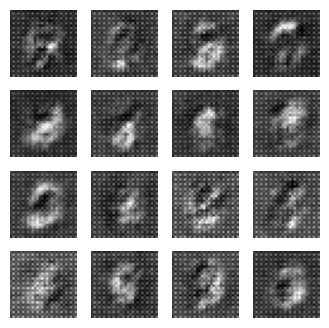

Epoch 1/100
Generator Loss: 1.4130, Discriminator Loss: 0.8617
Time for epoch 1 is 15.39 sec



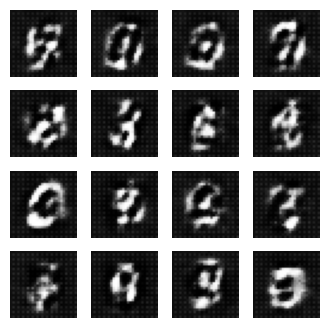

Epoch 2/100
Generator Loss: 1.4394, Discriminator Loss: 0.8765
Time for epoch 2 is 9.11 sec



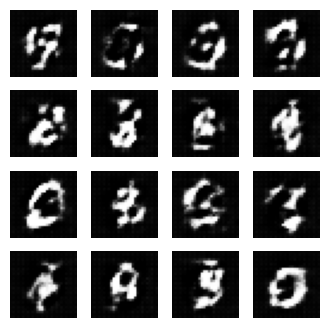

Epoch 3/100
Generator Loss: 1.4640, Discriminator Loss: 0.8396
Time for epoch 3 is 9.10 sec



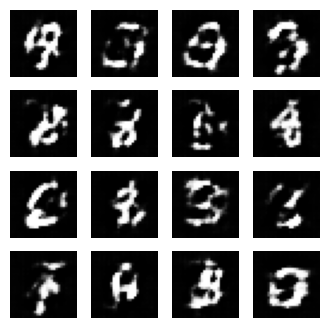

Epoch 4/100
Generator Loss: 1.4055, Discriminator Loss: 0.8967
Time for epoch 4 is 9.44 sec



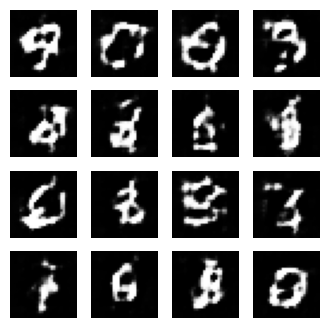

Epoch 5/100
Generator Loss: 1.3703, Discriminator Loss: 0.9259
Time for epoch 5 is 9.09 sec



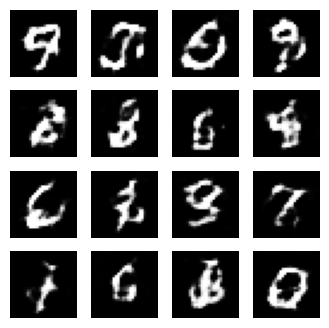

Epoch 6/100
Generator Loss: 1.3314, Discriminator Loss: 0.9655
Time for epoch 6 is 9.19 sec



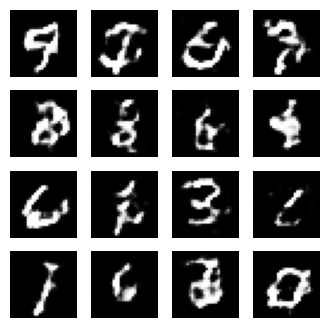

Epoch 7/100
Generator Loss: 1.2600, Discriminator Loss: 1.0457
Time for epoch 7 is 9.03 sec



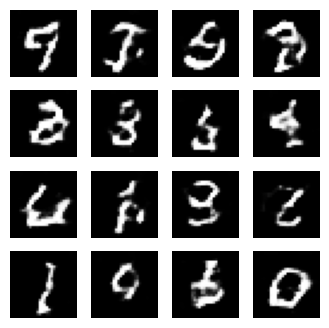

Epoch 8/100
Generator Loss: 1.1826, Discriminator Loss: 1.1099
Time for epoch 8 is 8.97 sec



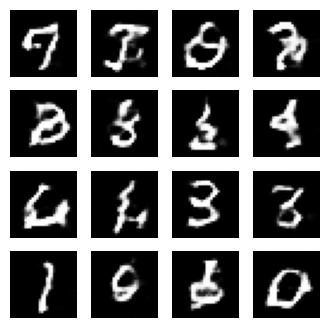

Epoch 9/100
Generator Loss: 1.1219, Discriminator Loss: 1.1611
Time for epoch 9 is 8.98 sec



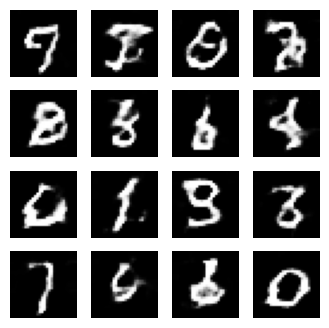

Epoch 10/100
Generator Loss: 1.0763, Discriminator Loss: 1.1932
Time for epoch 10 is 9.52 sec



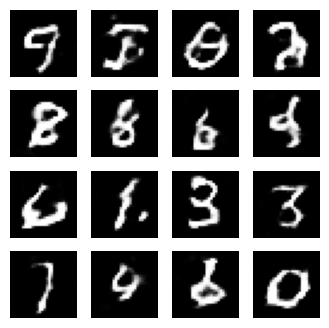

Epoch 11/100
Generator Loss: 1.0416, Discriminator Loss: 1.2163
Time for epoch 11 is 9.03 sec



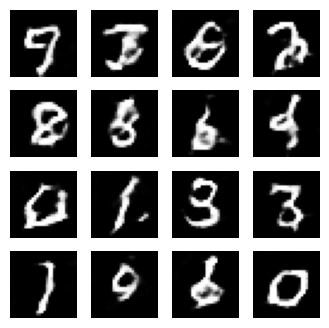

Epoch 12/100
Generator Loss: 1.0201, Discriminator Loss: 1.2244
Time for epoch 12 is 9.02 sec



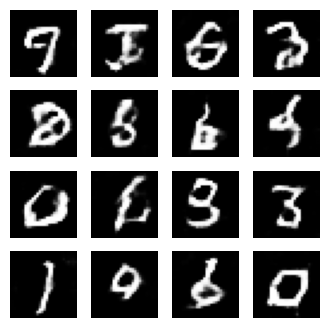

Epoch 13/100
Generator Loss: 1.0043, Discriminator Loss: 1.2301
Time for epoch 13 is 9.06 sec



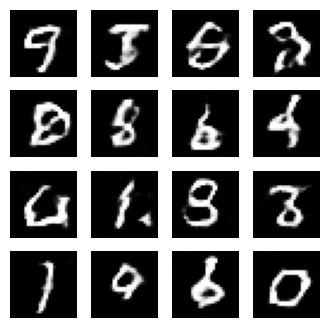

Epoch 14/100
Generator Loss: 0.9881, Discriminator Loss: 1.2351
Time for epoch 14 is 9.16 sec



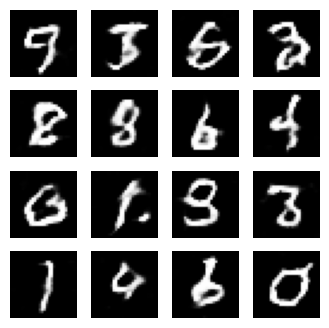

Epoch 15/100
Generator Loss: 0.9791, Discriminator Loss: 1.2369
Time for epoch 15 is 9.05 sec



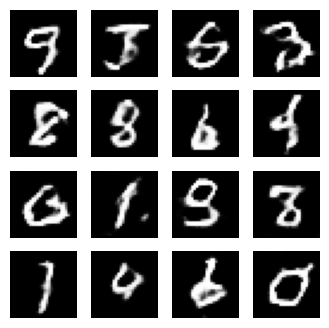

Epoch 16/100
Generator Loss: 0.9702, Discriminator Loss: 1.2384
Time for epoch 16 is 8.97 sec



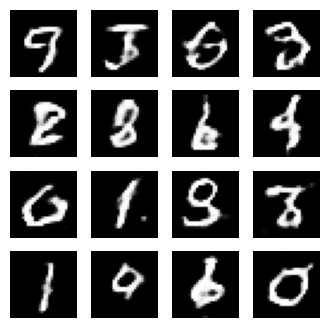

Epoch 17/100
Generator Loss: 0.9665, Discriminator Loss: 1.2388
Time for epoch 17 is 9.38 sec



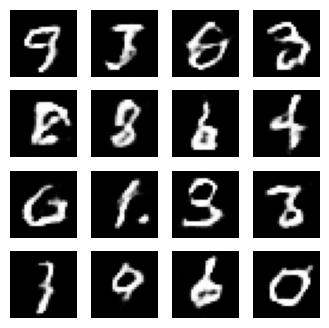

Epoch 18/100
Generator Loss: 0.9555, Discriminator Loss: 1.2441
Time for epoch 18 is 9.12 sec



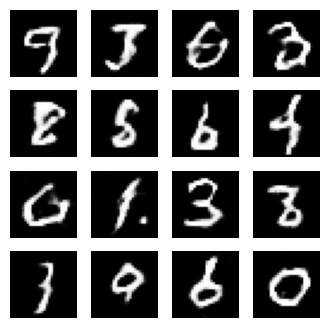

Epoch 19/100
Generator Loss: 0.9520, Discriminator Loss: 1.2401
Time for epoch 19 is 9.02 sec



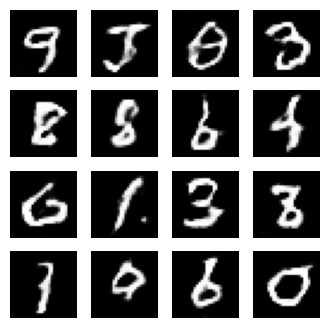

Epoch 20/100
Generator Loss: 0.9465, Discriminator Loss: 1.2427
Time for epoch 20 is 9.01 sec



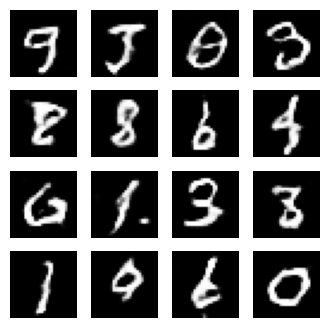

Epoch 21/100
Generator Loss: 0.9454, Discriminator Loss: 1.2415
Time for epoch 21 is 9.02 sec



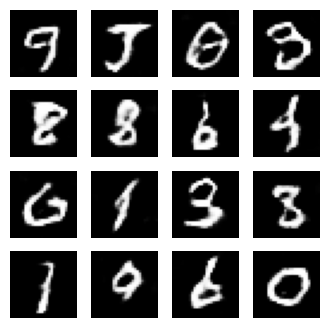

Epoch 22/100
Generator Loss: 0.9430, Discriminator Loss: 1.2384
Time for epoch 22 is 9.16 sec



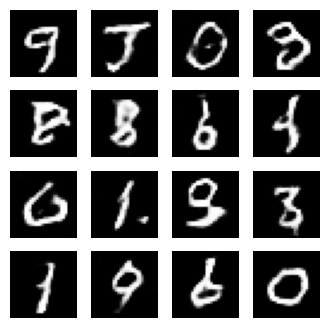

Epoch 23/100
Generator Loss: 0.9456, Discriminator Loss: 1.2345
Time for epoch 23 is 8.99 sec



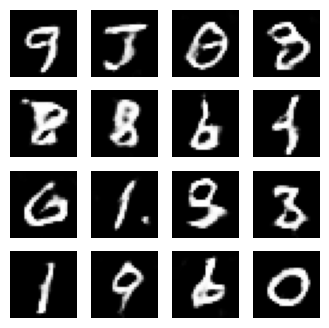

Epoch 24/100
Generator Loss: 0.9435, Discriminator Loss: 1.2359
Time for epoch 24 is 9.38 sec



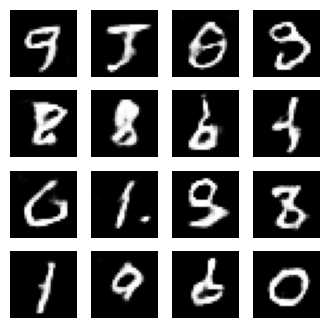

Epoch 25/100
Generator Loss: 0.9433, Discriminator Loss: 1.2342
Time for epoch 25 is 9.01 sec



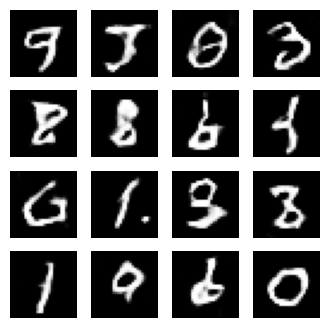

Epoch 26/100
Generator Loss: 0.9453, Discriminator Loss: 1.2274
Time for epoch 26 is 9.19 sec



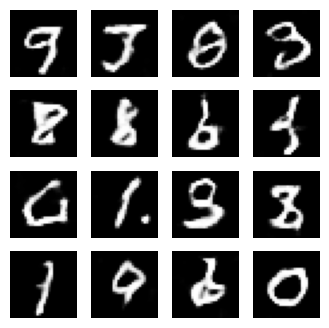

Epoch 27/100
Generator Loss: 0.9430, Discriminator Loss: 1.2319
Time for epoch 27 is 9.02 sec



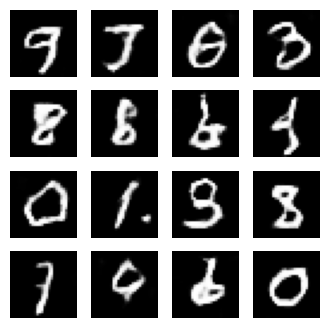

Epoch 28/100
Generator Loss: 0.9475, Discriminator Loss: 1.2254
Time for epoch 28 is 9.02 sec



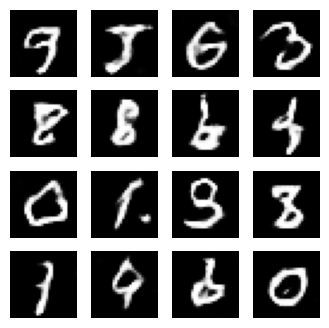

Epoch 29/100
Generator Loss: 0.9486, Discriminator Loss: 1.2263
Time for epoch 29 is 9.04 sec



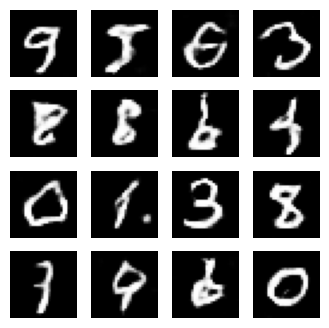

Epoch 30/100
Generator Loss: 0.9531, Discriminator Loss: 1.2209
Time for epoch 30 is 9.22 sec



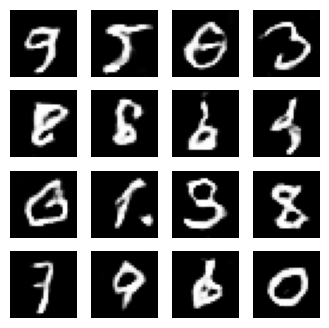

Epoch 31/100
Generator Loss: 0.9486, Discriminator Loss: 1.2250
Time for epoch 31 is 9.37 sec



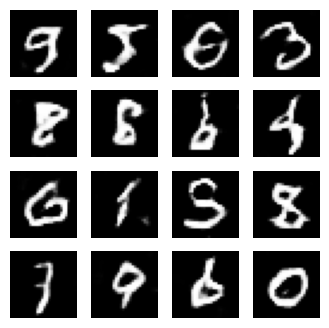

Epoch 32/100
Generator Loss: 0.9530, Discriminator Loss: 1.2183
Time for epoch 32 is 9.03 sec



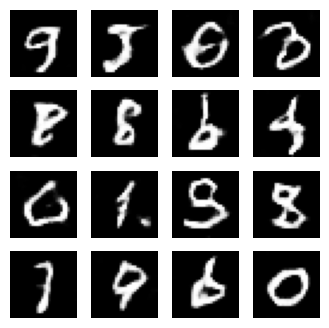

Epoch 33/100
Generator Loss: 0.9578, Discriminator Loss: 1.2131
Time for epoch 33 is 9.04 sec



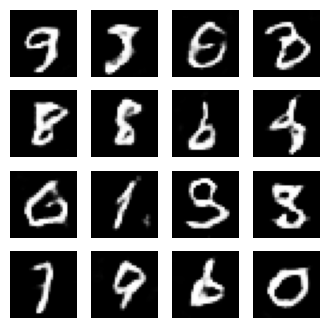

Epoch 34/100
Generator Loss: 0.9557, Discriminator Loss: 1.2215
Time for epoch 34 is 9.21 sec



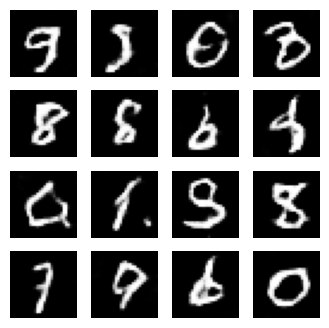

Epoch 35/100
Generator Loss: 0.9624, Discriminator Loss: 1.2103
Time for epoch 35 is 9.02 sec



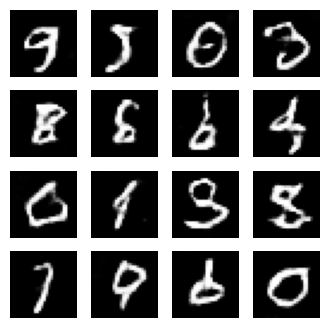

Epoch 36/100
Generator Loss: 0.9578, Discriminator Loss: 1.2161
Time for epoch 36 is 9.01 sec



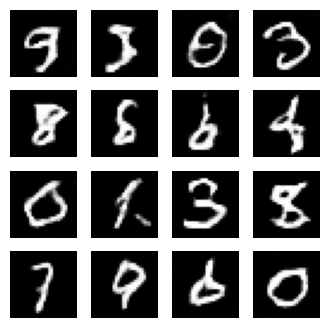

Epoch 37/100
Generator Loss: 0.9663, Discriminator Loss: 1.2068
Time for epoch 37 is 9.00 sec



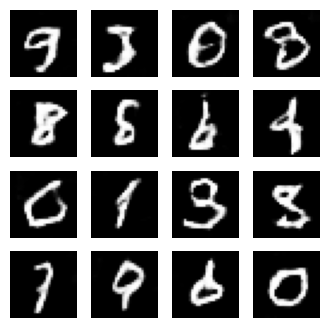

Epoch 38/100
Generator Loss: 0.9633, Discriminator Loss: 1.2152
Time for epoch 38 is 9.59 sec



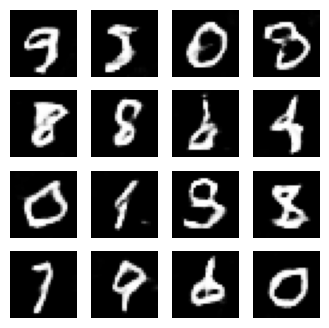

Epoch 39/100
Generator Loss: 0.9656, Discriminator Loss: 1.2124
Time for epoch 39 is 9.05 sec



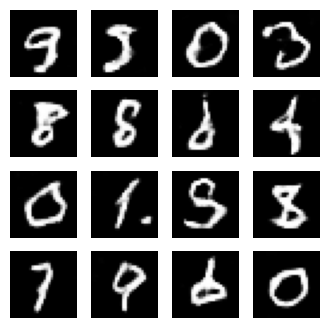

Epoch 40/100
Generator Loss: 0.9712, Discriminator Loss: 1.2025
Time for epoch 40 is 9.02 sec



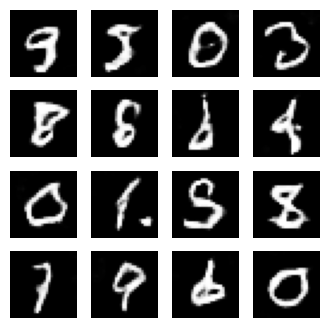

Epoch 41/100
Generator Loss: 0.9793, Discriminator Loss: 1.1975
Time for epoch 41 is 9.02 sec



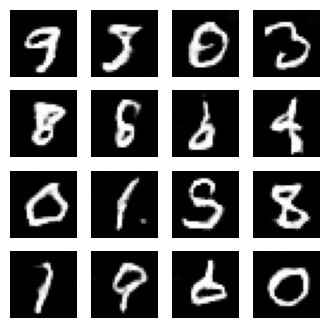

Epoch 42/100
Generator Loss: 0.9758, Discriminator Loss: 1.1999
Time for epoch 42 is 9.19 sec



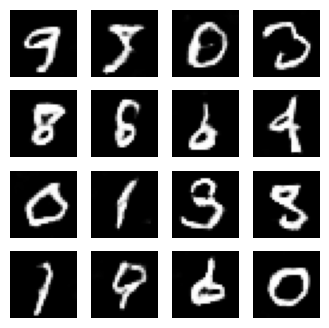

Epoch 43/100
Generator Loss: 0.9780, Discriminator Loss: 1.2004
Time for epoch 43 is 9.05 sec



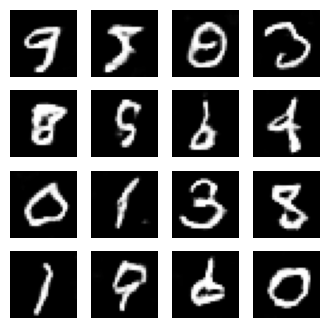

Epoch 44/100
Generator Loss: 0.9843, Discriminator Loss: 1.1919
Time for epoch 44 is 9.04 sec



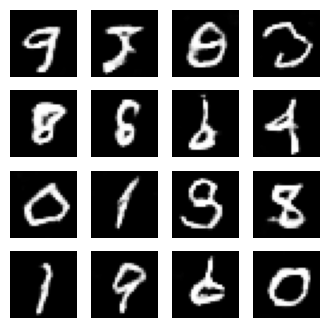

Epoch 45/100
Generator Loss: 0.9905, Discriminator Loss: 1.1909
Time for epoch 45 is 9.37 sec



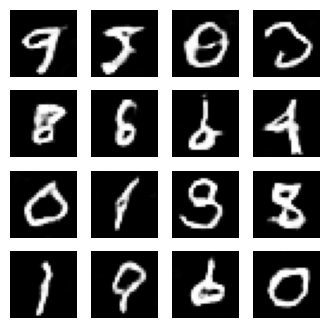

Epoch 46/100
Generator Loss: 0.9850, Discriminator Loss: 1.1957
Time for epoch 46 is 9.04 sec



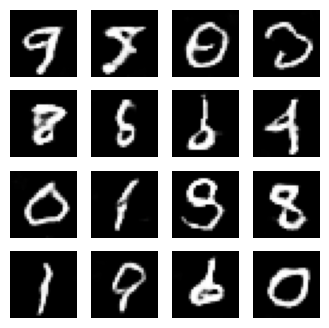

Epoch 47/100
Generator Loss: 0.9959, Discriminator Loss: 1.1843
Time for epoch 47 is 9.01 sec



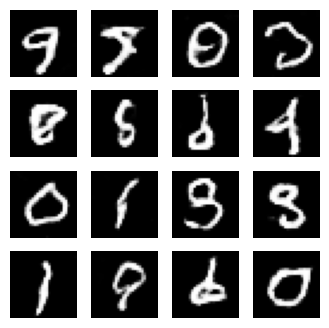

Epoch 48/100
Generator Loss: 1.0021, Discriminator Loss: 1.1797
Time for epoch 48 is 9.02 sec



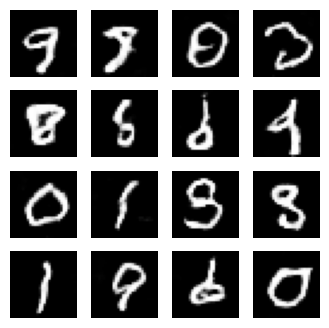

Epoch 49/100
Generator Loss: 1.0041, Discriminator Loss: 1.1806
Time for epoch 49 is 9.05 sec



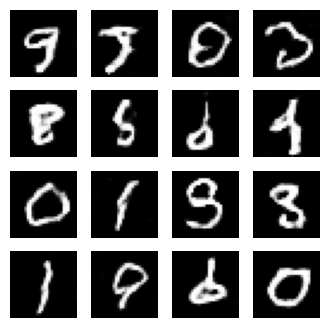

Epoch 50/100
Generator Loss: 1.0053, Discriminator Loss: 1.1782
Time for epoch 50 is 9.10 sec



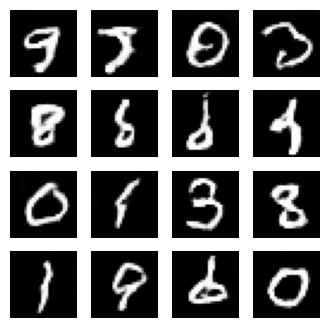

Epoch 51/100
Generator Loss: 1.0058, Discriminator Loss: 1.1789
Time for epoch 51 is 9.35 sec



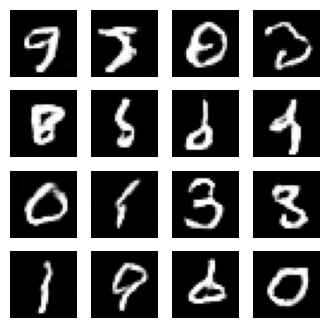

Epoch 52/100
Generator Loss: 1.0108, Discriminator Loss: 1.1753
Time for epoch 52 is 9.03 sec



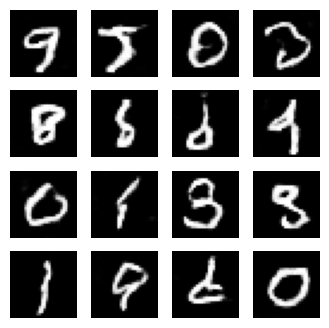

Epoch 53/100
Generator Loss: 1.0084, Discriminator Loss: 1.1814
Time for epoch 53 is 9.04 sec



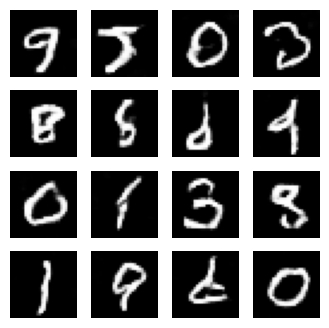

Epoch 54/100
Generator Loss: 1.0125, Discriminator Loss: 1.1764
Time for epoch 54 is 9.06 sec



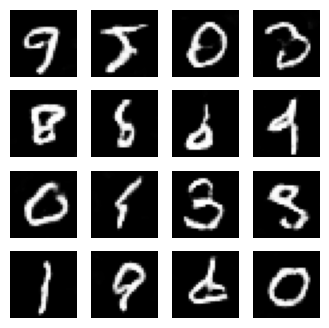

Epoch 55/100
Generator Loss: 1.0201, Discriminator Loss: 1.1715
Time for epoch 55 is 9.03 sec



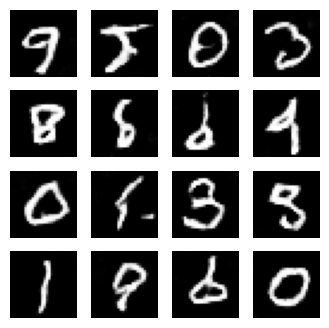

Epoch 56/100
Generator Loss: 1.0217, Discriminator Loss: 1.1667
Time for epoch 56 is 9.03 sec



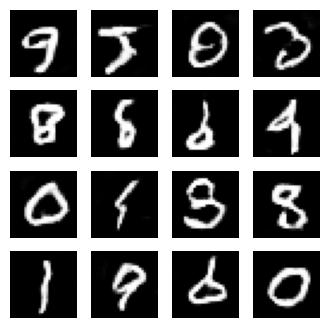

Epoch 57/100
Generator Loss: 1.0329, Discriminator Loss: 1.1549
Time for epoch 57 is 9.01 sec



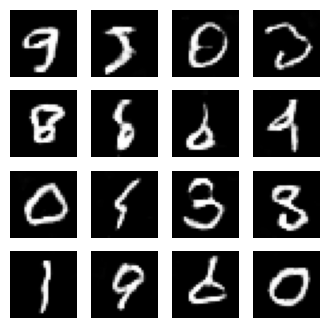

Epoch 58/100
Generator Loss: 1.0319, Discriminator Loss: 1.1593
Time for epoch 58 is 9.38 sec



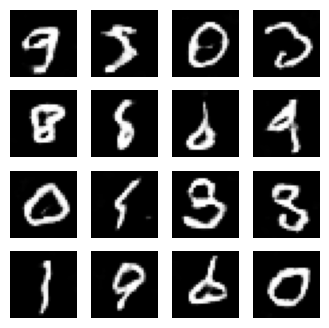

Epoch 59/100
Generator Loss: 1.0358, Discriminator Loss: 1.1633
Time for epoch 59 is 9.00 sec



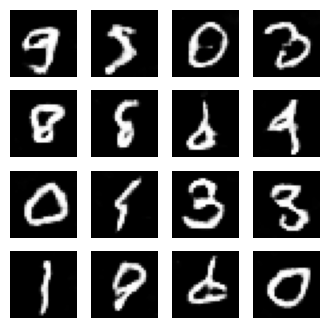

Epoch 60/100
Generator Loss: 1.0320, Discriminator Loss: 1.1615
Time for epoch 60 is 9.02 sec



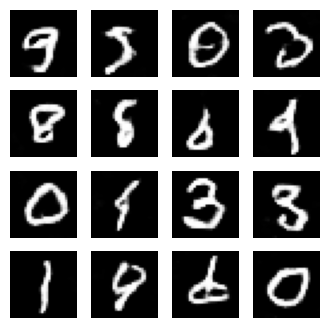

Epoch 61/100
Generator Loss: 1.0404, Discriminator Loss: 1.1544
Time for epoch 61 is 8.97 sec



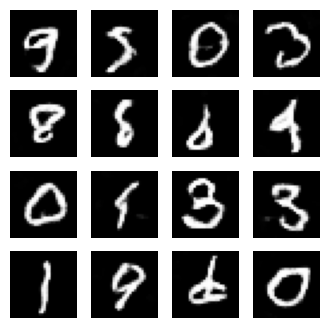

Epoch 62/100
Generator Loss: 1.0404, Discriminator Loss: 1.1614
Time for epoch 62 is 9.01 sec



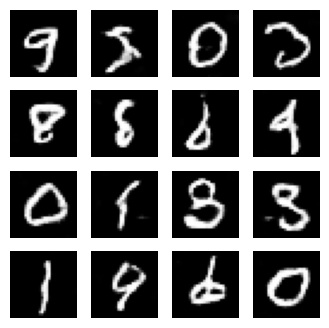

Epoch 63/100
Generator Loss: 1.0456, Discriminator Loss: 1.1564
Time for epoch 63 is 9.01 sec



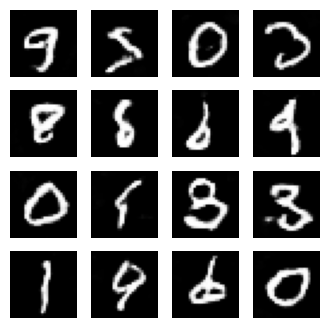

Epoch 64/100
Generator Loss: 1.0509, Discriminator Loss: 1.1485
Time for epoch 64 is 9.01 sec



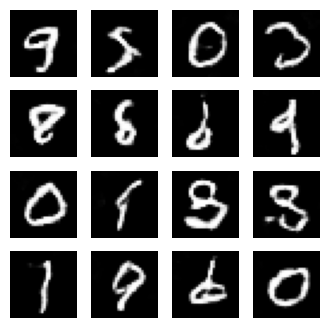

Epoch 65/100
Generator Loss: 1.0480, Discriminator Loss: 1.1590
Time for epoch 65 is 9.39 sec



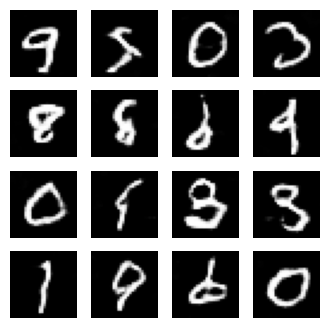

Epoch 66/100
Generator Loss: 1.0520, Discriminator Loss: 1.1468
Time for epoch 66 is 9.04 sec



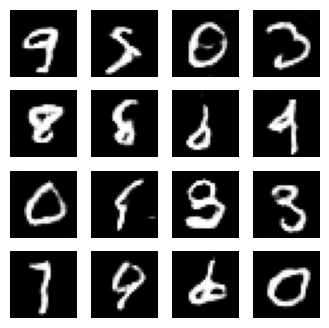

Epoch 67/100
Generator Loss: 1.0562, Discriminator Loss: 1.1477
Time for epoch 67 is 8.99 sec



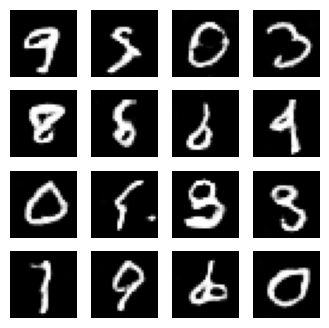

Epoch 68/100
Generator Loss: 1.0597, Discriminator Loss: 1.1520
Time for epoch 68 is 9.00 sec



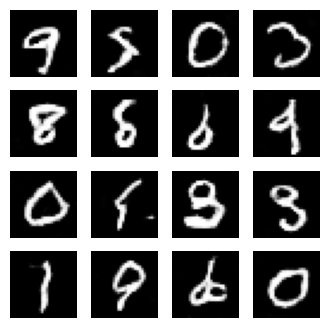

Epoch 69/100
Generator Loss: 1.0722, Discriminator Loss: 1.1336
Time for epoch 69 is 9.00 sec



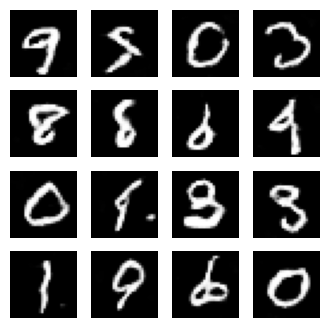

Epoch 70/100
Generator Loss: 1.0677, Discriminator Loss: 1.1445
Time for epoch 70 is 9.00 sec



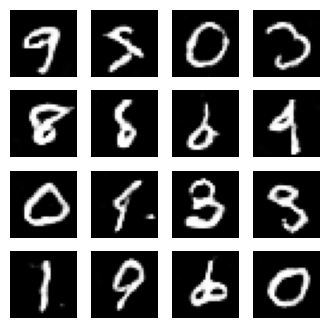

Epoch 71/100
Generator Loss: 1.0661, Discriminator Loss: 1.1407
Time for epoch 71 is 9.03 sec



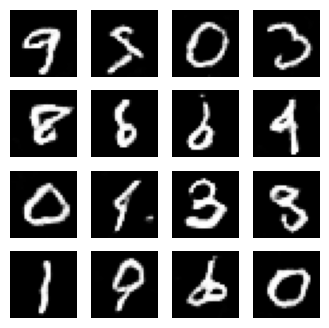

Epoch 72/100
Generator Loss: 1.0722, Discriminator Loss: 1.1346
Time for epoch 72 is 9.38 sec



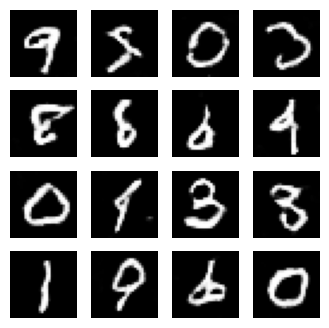

Epoch 73/100
Generator Loss: 1.0731, Discriminator Loss: 1.1370
Time for epoch 73 is 9.03 sec



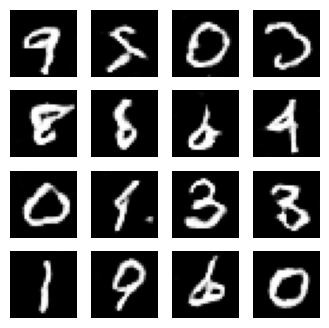

Epoch 74/100
Generator Loss: 1.0775, Discriminator Loss: 1.1325
Time for epoch 74 is 9.04 sec



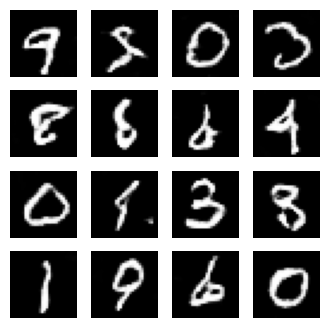

Epoch 75/100
Generator Loss: 1.0795, Discriminator Loss: 1.1408
Time for epoch 75 is 9.03 sec



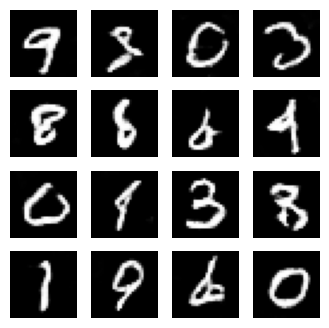

Epoch 76/100
Generator Loss: 1.0774, Discriminator Loss: 1.1387
Time for epoch 76 is 9.00 sec



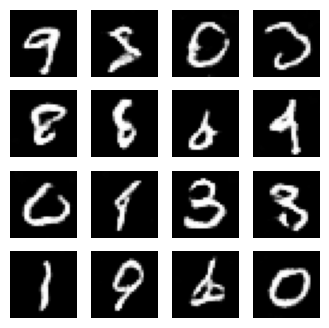

Epoch 77/100
Generator Loss: 1.0870, Discriminator Loss: 1.1246
Time for epoch 77 is 9.02 sec



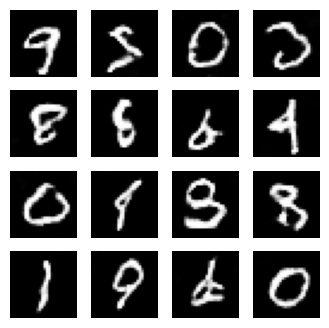

Epoch 78/100
Generator Loss: 1.0922, Discriminator Loss: 1.1233
Time for epoch 78 is 9.00 sec



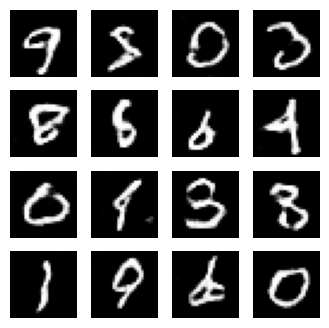

Epoch 79/100
Generator Loss: 1.0953, Discriminator Loss: 1.1269
Time for epoch 79 is 9.43 sec



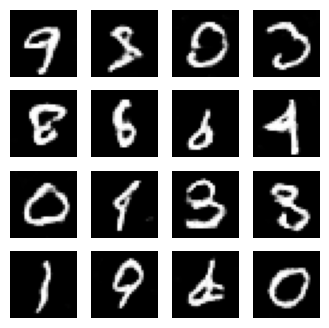

Epoch 80/100
Generator Loss: 1.0926, Discriminator Loss: 1.1255
Time for epoch 80 is 9.03 sec



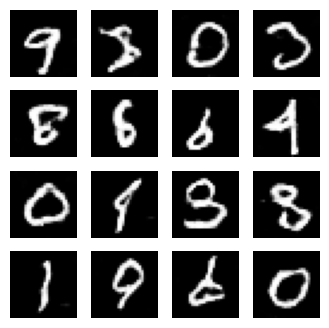

Epoch 81/100
Generator Loss: 1.1032, Discriminator Loss: 1.1108
Time for epoch 81 is 9.00 sec



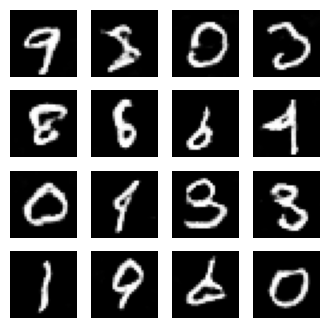

Epoch 82/100
Generator Loss: 1.1067, Discriminator Loss: 1.1242
Time for epoch 82 is 9.03 sec



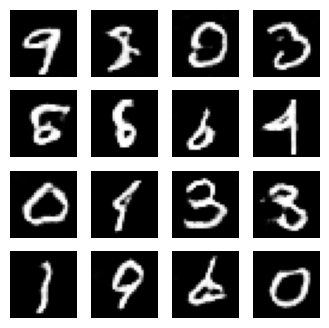

Epoch 83/100
Generator Loss: 1.1045, Discriminator Loss: 1.1185
Time for epoch 83 is 9.01 sec



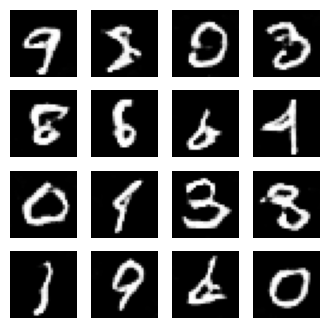

Epoch 84/100
Generator Loss: 1.1063, Discriminator Loss: 1.1122
Time for epoch 84 is 9.05 sec



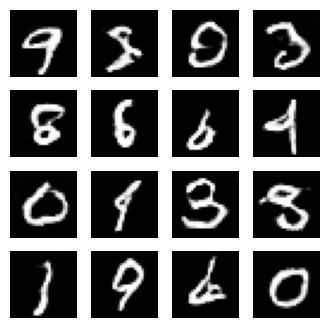

Epoch 85/100
Generator Loss: 1.1079, Discriminator Loss: 1.1257
Time for epoch 85 is 9.05 sec



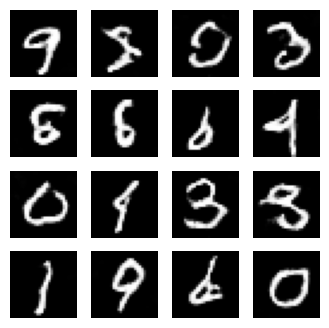

Epoch 86/100
Generator Loss: 1.1148, Discriminator Loss: 1.1125
Time for epoch 86 is 9.41 sec



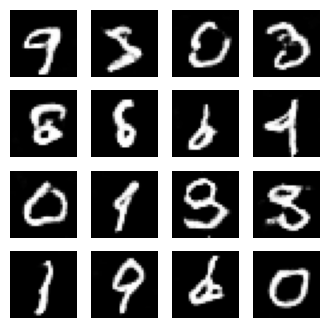

Epoch 87/100
Generator Loss: 1.1137, Discriminator Loss: 1.1144
Time for epoch 87 is 9.25 sec



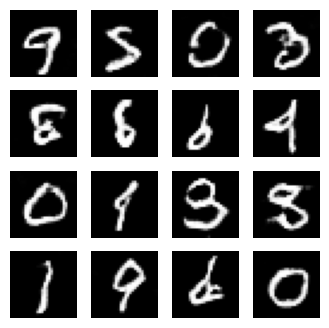

Epoch 88/100
Generator Loss: 1.1259, Discriminator Loss: 1.1006
Time for epoch 88 is 9.05 sec



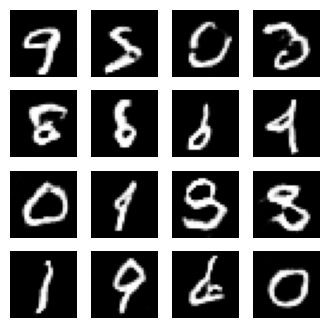

Epoch 89/100
Generator Loss: 1.1233, Discriminator Loss: 1.0998
Time for epoch 89 is 9.02 sec



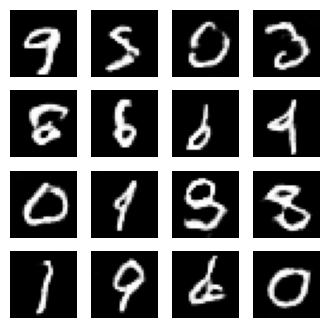

Epoch 90/100
Generator Loss: 1.1212, Discriminator Loss: 1.1256
Time for epoch 90 is 9.02 sec



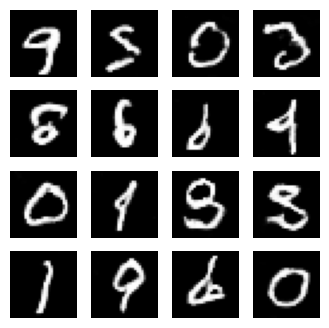

Epoch 91/100
Generator Loss: 1.1149, Discriminator Loss: 1.1130
Time for epoch 91 is 9.17 sec



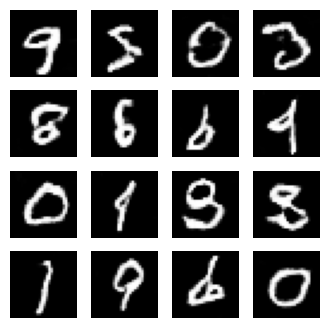

Epoch 92/100
Generator Loss: 1.1221, Discriminator Loss: 1.1179
Time for epoch 92 is 9.04 sec



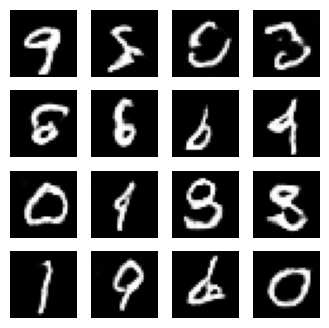

Epoch 93/100
Generator Loss: 1.1180, Discriminator Loss: 1.1144
Time for epoch 93 is 9.45 sec



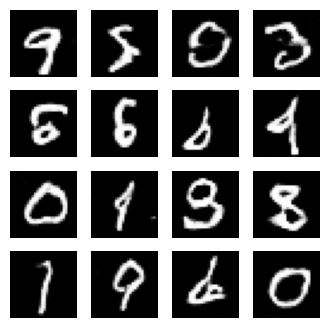

Epoch 94/100
Generator Loss: 1.1180, Discriminator Loss: 1.1097
Time for epoch 94 is 9.05 sec



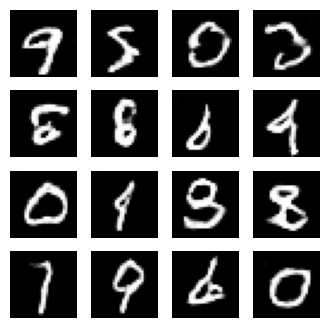

Epoch 95/100
Generator Loss: 1.1275, Discriminator Loss: 1.1061
Time for epoch 95 is 9.16 sec



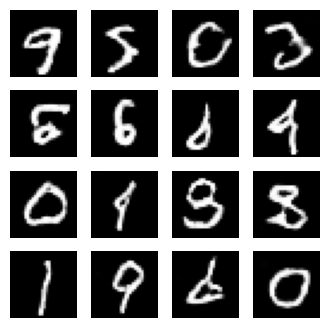

Epoch 96/100
Generator Loss: 1.1347, Discriminator Loss: 1.0986
Time for epoch 96 is 9.06 sec



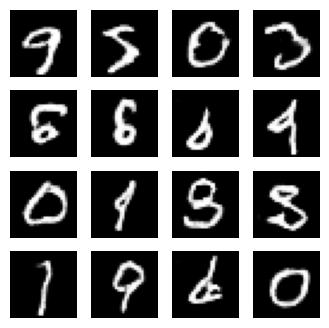

Epoch 97/100
Generator Loss: 1.1278, Discriminator Loss: 1.1205
Time for epoch 97 is 9.02 sec



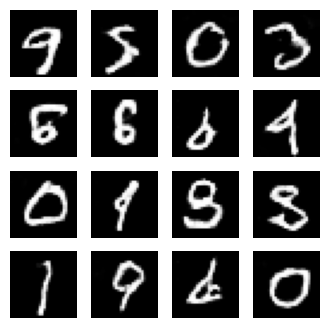

Epoch 98/100
Generator Loss: 1.1420, Discriminator Loss: 1.0875
Time for epoch 98 is 9.05 sec



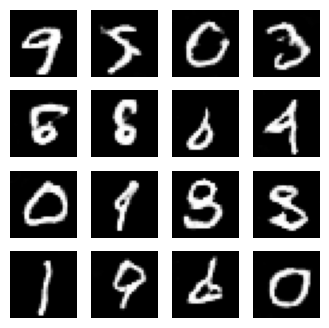

Epoch 99/100
Generator Loss: 1.1366, Discriminator Loss: 1.1114
Time for epoch 99 is 9.16 sec



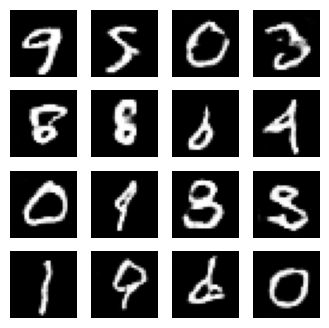

Epoch 100/100
Generator Loss: 1.1521, Discriminator Loss: 1.0938
Time for epoch 100 is 9.41 sec



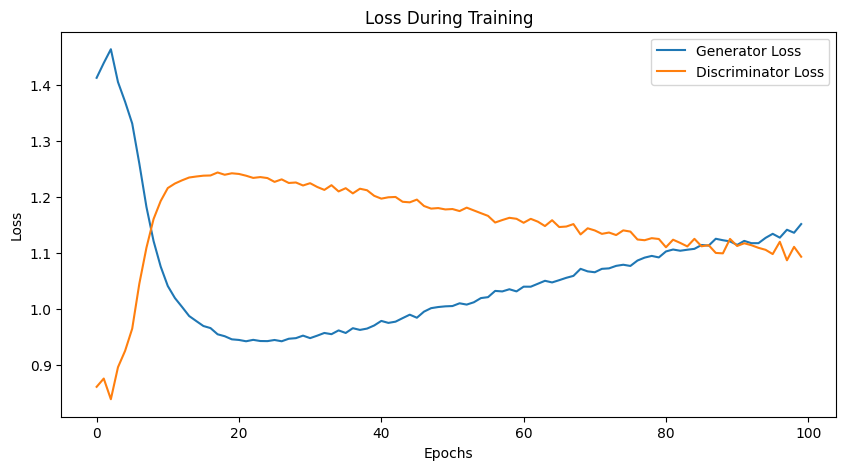

In [51]:
train(train_dataset, EPOCHS)